# Project 1- Convolutional neural networks

In [1]:
import torch
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time

print("CUDA dostępna:", torch.cuda.is_available())
print("Nazwa GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Brak")


CUDA dostępna: True
Nazwa GPU: NVIDIA GeForce RTX 3070 Ti


In [2]:
cinic_mean = [0.47889522, 0.47227842, 0.43047404]
cinic_std = [0.24205776, 0.23828046, 0.25874835]

def read_paired_data_to_memory(cinic_directory, device):
    dataset = torchvision.datasets.ImageFolder(
                cinic_directory,
                transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean = cinic_mean, std = cinic_std)
                        ]))
    images = torch.stack([img for img, _ in dataset], dim =0).to(device)
    labels = torch.tensor(dataset.targets, dtype=torch.long, device= device)
    return list(zip(images, labels))
    

# Use this function if you do not have enough VRAM on your GPU
def make_datase_for_stream(
        cinic_directory
        , transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=cinic_mean, std=cinic_std),
        ])
    ):
    return torchvision.datasets.ImageFolder(
                cinic_directory,
                transform = transform
    )

In [56]:
def get_data_loader_for_memory(paired_data, batch_size, shuffle = True):
    return torch.utils.data.DataLoader(paired_data
                                       , batch_size=batch_size
                                       , shuffle=shuffle
                                       )

def get_data_loader_streamer(dataset, batch_size, num_workers = 16, pin_memory = True):
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers = num_workers,
        pin_memory = pin_memory # Faster CPU ->  GPU transfer
    )

In [4]:
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

cinic_directory_train = './archive/train'
cinic_directory_valid = './archive/valid'
cinic_directory_test = './archive/test'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[LOG]: Device = {device.type}")

train_data = read_paired_data_to_memory(cinic_directory_train, device)
print(f"[LOG]: Train dataset loaded to {device}")

test_data = read_paired_data_to_memory(cinic_directory_test, device)
print(f"[LOG]: Test dataset loaded to {device}")

valid_data = read_paired_data_to_memory(cinic_directory_valid, device)
print(f"[LOG]: Valid dataset loaded to {device}")

[LOG]: Device = cuda
[LOG]: Test dataset loaded to cuda
[LOG]: Valid dataset loaded to cuda


### SimpleCNN

`SimpleCNN` is a basic convolutional neural network designed for image classification tasks
It consists of two convolutional layers with ReLU activations and max pooling, followed by a simple fully connected (MLP) classifier. This model serves as a starting point for developing and comparing more advanced architectures in this project.

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        # kernel_size = n - filter_size: n x n
        #  padding = n - size of extra border n pixels
        # stride = n - number of pixels the filter moves. up/down
        super().__init__()
        #Conv part:
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding= 1, stride=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding= 1, stride=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, padding= 1, stride = 1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, padding= 2, stride=1)
        
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.flatten = nn.Flatten()
        #MLP part:
        H = 16
        W = 16
        self.fc1 = nn.Linear(H * W * 128, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

        


In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class MidCNN(nn.Module):
    def __init__(self, dropout_rate=0.4):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)  # 32 -> 16

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)  # 16 -> 8

        self.dropout = nn.Dropout(p=dropout_rate)
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(128 * 8 * 8, 128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn_fc2 = nn.BatchNorm1d(64)

        self.fc3 = nn.Linear(64, 32)
        self.bn_fc3 = nn.BatchNorm1d(32)

        self.fc4 = nn.Linear(32, 10)

        self._initialize_weights()

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(F.relu(self.bn2(self.conv2(x))))
        x = self.pool2(F.relu(self.bn3(self.conv3(x))))
        
        x = self.flatten(x)
        x = self.dropout(F.relu(self.bn_fc1(self.fc1(x))))
        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class ComplexCNN(nn.Module):
    def __init__(self, dropout_rate=0.4):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)  # 32 -> 16

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)  # 16 -> 8

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)  # 8x8 → 4x4


        self.dropout = nn.Dropout(p=dropout_rate)
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(256 * 4 * 4, 128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn_fc2 = nn.BatchNorm1d(64)

        self.fc3 = nn.Linear(64, 32)
        self.bn_fc3 = nn.BatchNorm1d(32)

        self.fc4 = nn.Linear(32, 10)

        self._initialize_weights()

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(F.relu(self.bn2(self.conv2(x))))
        x = self.pool2(F.relu(self.bn3(self.conv3(x))))
        x = self.pool3(F.relu(self.bn4(self.conv4(x))))

        x = self.flatten(x)
        x = self.dropout(F.relu(self.bn_fc1(self.fc1(x))))
        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def train_one_epoch(model, loader, optimizer, loss_fun, device, f_gradient_cliping = False):
    model.train()
    total_loss = 0
    batch_losses  = []
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad() # reset gradients before new epoch !!!!!!!!!!! very important !!!!!!!!!!!
        outputs = model(inputs)
        loss = loss_fun(outputs, labels) # calculate loss_function
        loss.backward() # gradient propagation
        
        if f_gradient_cliping:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        
        optimizer.step() # gradient actualization
        loss_value = loss.item()
        total_loss += loss_value
        batch_losses.append(loss_value)
    
    avg_loss = total_loss / len(loader)
    return avg_loss, batch_losses

def evaluate(model, loader, loss_fun, device):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    batch_losses = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fun(outputs, labels)
            loss_val = loss.item()
            total_loss += loss_val
            batch_losses.append(loss_val)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    accuracy = 100 * correct / total
    avg_loss = total_loss / len(loader)
    
    return avg_loss, accuracy, batch_losses

In [9]:
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve

def score_model(y_true, y_pred, model_name = "Model"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    print(f"Metrics for {model_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.2f}")
    print(f"Classification Report:\n{classification_report(y_true, y_pred)}")



In [10]:
def training_details_plot(batch_loses_train, batch_loses_validate, title, smoothness = 0.9):
    def smooth_curve(data, weight):
        smoothed = []
        last = data[0]
        for point in data:
            smoothed_val = last * weight + (1 - weight) * point
            smoothed.append(smoothed_val)
            last = smoothed_val
        return smoothed
    train_loses = smooth_curve(batch_loses_train, smoothness)
    valid_loses = smooth_curve(batch_loses_validate, smoothness)

    plt.figure(figsize=(10, 4))
    plt.plot(train_loses, label="Train Loss")
    plt.plot(valid_loses, label="Validation Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title(title)
    plt.grid(True)
    plt.show()


### Test 1
Hyper-parameters related to training process:
1. Learning Rate
2. batch_size
3. number of epochs

In [ ]:
import os
from collections import defaultdict

models_for_test1 = "saved_models_test1"
os.makedirs(models_for_test1, exist_ok=True)

results = defaultdict(list)
learning_rates = [0.01, 0.001, 0.0005]
batch_sizes = [128, 256]
number_of_epochs = [5, 7, 12]

for lr in learning_rates:
    for batch_size in batch_sizes:
        for epochs in number_of_epochs:

            model_1 = ComplexCNN().to(device)
            optimizer_adam_1 = torch.optim.Adam(model_1.parameters(), lr = lr)
            loss_fun_1 = nn.CrossEntropyLoss()

            train_losses = []
            val_losses = []
            val_accuracies = []
            batch_losses_train_all = []
            batch_losses_valid_all = []

            for epoch in range(1, epochs + 1):
                train_loss, batch_losses_train = train_one_epoch(model_1, get_data_loader_for_memory(train_data, batch_size), optimizer_adam_1, loss_fun_1, device)
                val_loss, val_acc, batch_losses_valid = evaluate(model_1, get_data_loader_for_memory(valid_data, batch_size), loss_fun_1, device)

                train_losses.append(train_loss)
                val_losses.append(val_loss)
                val_accuracies.append(val_acc)
                batch_losses_train_all.extend(batch_losses_train)
                batch_losses_valid_all.extend(batch_losses_valid)

                print(f"[Epoch {epoch}/{epochs}] Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, Val acc: {val_acc:.2f}% || lr = {lr}, batch_size = {batch_size}")

            config_key = f"lr{lr}_bs{batch_size}_ep{epochs}"
            model_path = f"{models_for_test1}/model_{config_key}.pt"
            torch.save(model_1.state_dict(), model_path)
            print(f"[LOG] model = model_{config_key} | Saved")

            results[config_key] = {
                "train_losses": train_losses,
                "val_losses": val_losses,
                "val_accuracies": val_accuracies,
                "batch_losses_train": batch_losses_train_all,
                "batch_losses_valid": batch_losses_valid_all,
                "model_path": model_path,
            }

In [ ]:
for config_name, data in results.items():
    print(f"\n=== Configuration: {config_name} ===")

    model = ComplexCNN().to(device)
    model.load_state_dict(torch.load(data["model_path"]))
    model.eval()
    
    # Rysuj loss plot
    training_details_plot(
        data["batch_losses_train"],
        data["batch_losses_valid"],
        title=f"Loss per iteration - {config_name}",
        smoothness=0.98
    )

    # Predykcja na zbiorze testowym
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in get_data_loader_for_memory(test_data, 128):  # lub batch_size z konfiguracji
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # # Wyświetl metryki
    score_model(all_labels, all_preds, model_name=config_name)


### Test 2

hyper-parameters related to regularization

In [ ]:
import os
from collections import defaultdict

models_for_test2 = "saved_models_test2"
os.makedirs(models_for_test2, exist_ok=True)

dropout_rates = [0.0, 0.25, 0.5]
weight_decays = [0.0, 1e-4, 1e-3]
results_2 = defaultdict(dict)

lr = 0.001
batch_size = 256
epochs = 10

for dropout_rate in dropout_rates:
    for weight_decay in weight_decays:
        config_key = f"dr{dropout_rate}_wd{weight_decay}"
        print(f"\n=== Training config: {config_key} ===")

        model_2 = ComplexCNN(dropout_rate=dropout_rate).to(device)
        optimizer = torch.optim.Adam(model_2.parameters(), lr=lr, weight_decay = weight_decay)
        loss_fun = nn.CrossEntropyLoss()

        train_losses = []
        val_losses = []
        val_accuracies = []
        batch_losses_train_all = []
        batch_losses_valid_all = []

        for epoch in range(1, epochs + 1):
            train_loss, batch_losses_train = train_one_epoch(
                model_2, get_data_loader_for_memory(train_data, batch_size),
                optimizer, loss_fun, device
            )
            val_loss, val_acc, batch_losses_valid = evaluate(
                model_2, get_data_loader_for_memory(valid_data, batch_size),
                loss_fun, device
            )

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            batch_losses_train_all.extend(batch_losses_train)
            batch_losses_valid_all.extend(batch_losses_valid)

            print(f"[Epoch {epoch}/{epochs}] Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, Val acc: {val_acc:.2f}%")

        # Zapis modelu
        model_path = f"{models_for_test2}/model_{config_key}.pt"
        torch.save(model_2.state_dict(), model_path)
        print(f"[LOG] Model saved at: {model_path}")

        # Zapis wyników
        results_2[config_key] = {
            "train_losses": train_losses,
            "val_losses": val_losses,
            "val_accuracies": val_accuracies,
            "batch_losses_train": batch_losses_train_all,
            "batch_losses_valid": batch_losses_valid_all,
            "model_path": model_path,
            "dropout": dropout_rate,
            "weight_decay": weight_decay
        }


In [ ]:
for config_name, data in results_2.items():
    print(f"\n=== Configuration: {config_name} ===")

    # Załaduj model
    model = ComplexCNN(dropout_rate=data["dropout"]).to(device)
    model.load_state_dict(torch.load(data["model_path"]))
    model.eval()
    
    # Rysuj wykres strat
    training_details_plot(
        data["batch_losses_train"],
        data["batch_losses_valid"],
        title=f"Loss per iteration - {config_name}",
        smoothness=0.98
    )

    # Predykcja na zbiorze testowym
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in get_data_loader_for_memory(test_data, 128):  # lub inny batch_size
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Wyświetl metryki
    score_model(all_labels, all_preds, model_name=config_name)


### Augmentation

before this step create agmented dataset with script: augmentation.ipynb

In [11]:
del train_data
torch.cuda.empty_cache()

NameError: name 'train_data' is not defined

In [12]:
cinic_directory_train_augmented = './archive/train_augment_standard_3_copies'

train_data_augmented = read_paired_data_to_memory(cinic_directory_train_augmented, device)
print(f"[LOG]: Train augmented dataset loaded to {device}")

[LOG]: Train augmented dataset loaded to cuda


In [ ]:
import os
from collections import defaultdict

models_for_test_augmented_standard = "saved_models_test_augmented_standard"
os.makedirs(models_for_test_augmented_standard, exist_ok=True)

results_augmented_standard = defaultdict(list)
# learning_rates = [0.01, 0.001, 0.0005]
# batch_sizes = [128, 256]
# number_of_epochs = [5, 7, 12]

learning_rates = [0.001]
batch_sizes = [256]
number_of_epochs = [14]

for lr in learning_rates:
    for batch_size in batch_sizes:
        for epochs in number_of_epochs:

            model_1 = ComplexCNN(dropout_rate = 0.5).to(device)
            optimizer_adam_1 = torch.optim.Adam(model_1.parameters(), lr = lr, weight_decay = 1e-4)
            loss_fun_1 = nn.CrossEntropyLoss()

            train_losses = []
            val_losses = []
            val_accuracies = []
            batch_losses_train_all = []
            batch_losses_valid_all = []

            for epoch in range(1, epochs + 1):
                train_loss, batch_losses_train = train_one_epoch(model_1, get_data_loader_for_memory(train_data_augmented, batch_size), optimizer_adam_1, loss_fun_1, device)
                val_loss, val_acc, batch_losses_valid = evaluate(model_1, get_data_loader_for_memory(valid_data, batch_size), loss_fun_1, device)

                train_losses.append(train_loss)
                val_losses.append(val_loss)
                val_accuracies.append(val_acc)
                batch_losses_train_all.extend(batch_losses_train)
                batch_losses_valid_all.extend(batch_losses_valid)

                print(f"[Epoch {epoch}/{epochs}] Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, Val acc: {val_acc:.2f}% || lr = {lr}, batch_size = {batch_size}")

            config_key = f"lr{lr}_bs{batch_size}_ep{epochs}"
            model_path = f"{models_for_test_augmented_standard}/model_{config_key}.pt"
            torch.save(model_1.state_dict(), model_path)
            print(f"[LOG] model = model_{config_key} | Saved")

            results_augmented_standard[config_key] = {
                "train_losses": train_losses,
                "val_losses": val_losses,
                "val_accuracies": val_accuracies,
                "batch_losses_train": batch_losses_train_all,
                "batch_losses_valid": batch_losses_valid_all,
                "model_path": model_path,
            }

[Epoch 1/15] Train loss: 1.4996, Val loss: 1.1798, Val acc: 56.98% || lr = 0.001, batch_size = 256
[Epoch 2/15] Train loss: 1.2033, Val loss: 1.0197, Val acc: 63.59% || lr = 0.001, batch_size = 256
[Epoch 3/15] Train loss: 1.0776, Val loss: 0.9468, Val acc: 66.25% || lr = 0.001, batch_size = 256
[Epoch 4/15] Train loss: 0.9913, Val loss: 0.8790, Val acc: 68.52% || lr = 0.001, batch_size = 256
[Epoch 5/15] Train loss: 0.9205, Val loss: 0.9105, Val acc: 67.90% || lr = 0.001, batch_size = 256
[Epoch 6/15] Train loss: 0.8614, Val loss: 0.8400, Val acc: 70.31% || lr = 0.001, batch_size = 256
[Epoch 7/15] Train loss: 0.8108, Val loss: 0.8441, Val acc: 70.68% || lr = 0.001, batch_size = 256
[Epoch 8/15] Train loss: 0.7661, Val loss: 0.8197, Val acc: 71.65% || lr = 0.001, batch_size = 256
[Epoch 9/15] Train loss: 0.7289, Val loss: 0.8711, Val acc: 70.17% || lr = 0.001, batch_size = 256
[Epoch 10/15] Train loss: 0.6927, Val loss: 0.8219, Val acc: 71.91% || lr = 0.001, batch_size = 256
[Epoch 11


=== Configuration: lr0.001_bs256_ep15 ===


/tmp/ipykernel_2556/3952285506.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(data["model_path"]))


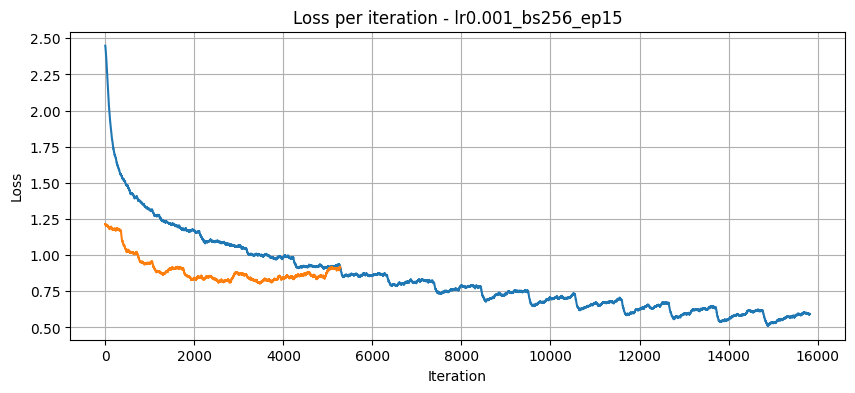

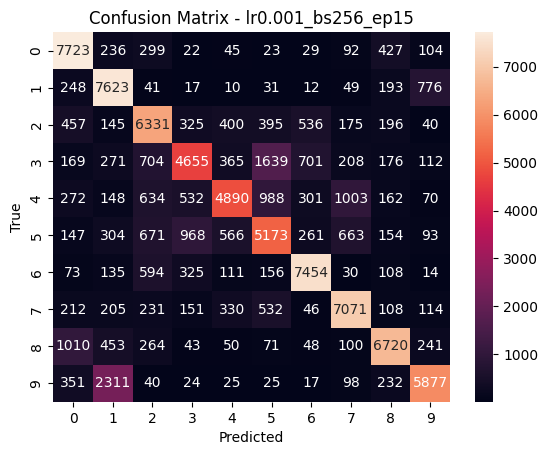

Metrics for lr0.001_bs256_ep15:
Accuracy: 0.71
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.86      0.79      9000
           1       0.64      0.85      0.73      9000
           2       0.65      0.70      0.67      9000
           3       0.66      0.52      0.58      9000
           4       0.72      0.54      0.62      9000
           5       0.57      0.57      0.57      9000
           6       0.79      0.83      0.81      9000
           7       0.75      0.79      0.76      9000
           8       0.79      0.75      0.77      9000
           9       0.79      0.65      0.71      9000

    accuracy                           0.71     90000
   macro avg       0.71      0.71      0.70     90000
weighted avg       0.71      0.71      0.70     90000



In [14]:
for config_name, data in results_augmented_standard.items():
    print(f"\n=== Configuration: {config_name} ===")

    model = ComplexCNN(dropout_rate = 0.5).to(device)
    model.load_state_dict(torch.load(data["model_path"]))
    model.eval()
    
    # Rysuj loss plot
    training_details_plot(
        data["batch_losses_train"],
        data["batch_losses_valid"],
        title=f"Loss per iteration - {config_name}",
        smoothness=0.98
    )

    # Predykcja na zbiorze testowym
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in get_data_loader_for_memory(test_data, 256):  # lub batch_size z konfiguracji
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # # Wyświetl metryki
    score_model(all_labels, all_preds, model_name=config_name)

In [ ]:
del train_data_augmented
torch.cuda.empty_cache()

In [ ]:
cinic_directory_train_augmented = './archive/train_augment_advanced_3_copies'

train_data_augmented = read_paired_data_to_memory(cinic_directory_train_augmented, device)
print(f"[LOG]: Train augmented dataset loaded to {device}")

In [ ]:
import os
from collections import defaultdict

models_for_test_augmented_advanced = "saved_models_test_augmented_advanced"
os.makedirs(models_for_test_augmented_advanced, exist_ok=True)

results_augmented_advanced = defaultdict(list)
# learning_rates = [0.01, 0.001, 0.0005]
# batch_sizes = [128, 256]
# number_of_epochs = [5, 7, 12]

learning_rates = [0.001]
batch_sizes = [256]
number_of_epochs = [10]

for lr in learning_rates:
    for batch_size in batch_sizes:
        for epochs in number_of_epochs:

            model_1 = ComplexCNN(dropout_rate = 0.5).to(device)
            optimizer_adam_1 = torch.optim.Adam(model_1.parameters(), lr = lr, weight_decay = 1e-4)
            loss_fun_1 = nn.CrossEntropyLoss()

            train_losses = []
            val_losses = []
            val_accuracies = []
            batch_losses_train_all = []
            batch_losses_valid_all = []

            for epoch in range(1, epochs + 1):
                train_loss, batch_losses_train = train_one_epoch(model_1, get_data_loader_for_memory(train_data_augmented, batch_size), optimizer_adam_1, loss_fun_1, device)
                val_loss, val_acc, batch_losses_valid = evaluate(model_1, get_data_loader_for_memory(valid_data, batch_size), loss_fun_1, device)

                train_losses.append(train_loss)
                val_losses.append(val_loss)
                val_accuracies.append(val_acc)
                batch_losses_train_all.extend(batch_losses_train)
                batch_losses_valid_all.extend(batch_losses_valid)

                print(f"[Epoch {epoch}/{epochs}] Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, Val acc: {val_acc:.2f}% || lr = {lr}, batch_size = {batch_size}")

            config_key = f"lr{lr}_bs{batch_size}_ep{epochs}"
            model_path = f"{models_for_test_augmented_advanced}/model_{config_key}.pt"
            torch.save(model_1.state_dict(), model_path)
            print(f"[LOG] model = model_{config_key} | Saved")

            results_augmented_advanced[config_key] = {
                "train_losses": train_losses,
                "val_losses": val_losses,
                "val_accuracies": val_accuracies,
                "batch_losses_train": batch_losses_train_all,
                "batch_losses_valid": batch_losses_valid_all,
                "model_path": model_path,
            }

In [ ]:
for config_name, data in results_augmented_advanced.items():
    print(f"\n=== Configuration: {config_name} ===")

    model = ComplexCNN(dropout_rate = 0.5).to(device)
    model.load_state_dict(torch.load(data["model_path"]))
    model.eval()
    
    # Rysuj loss plot
    training_details_plot(
        data["batch_losses_train"],
        data["batch_losses_valid"],
        title=f"Loss per iteration - {config_name}",
        smoothness=0.98
    )

    # Predykcja na zbiorze testowym
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in get_data_loader_for_memory(test_data, 256):  # lub batch_size z konfiguracji
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # # Wyświetl metryki
    score_model(all_labels, all_preds, model_name=config_name)

In [15]:
del train_data_augmented
torch.cuda.empty_cache()

### Few-Shot Learning

In [17]:
import torchvision.models as models
from torch.utils.data import Subset
import random

In [19]:
def few_shot_subset(paired_dataset, shots_per_class):
    labels = [label.item() if isinstance(label, torch.Tensor) else label for _, label in paired_dataset]
    class_indices = {label: [] for label in set(labels)}
    for i, label in enumerate(labels):
        class_indices[label].append(i)
    selected_indices = []
    for label, indices in class_indices.items():
        selected = random.sample(indices, shots_per_class)
        selected_indices.extend(selected)
    fewshot_data = [paired_dataset[i] for i in selected_indices]
    return fewshot_data


cinic_directory_train = './archive/train'

train_data = read_paired_data_to_memory(cinic_directory_train, device)
print(f"[LOG]: Train dataset loaded to {device}")

fewshot_dataset = few_shot_subset(train_data, shots_per_class=25)


[LOG]: Train dataset loaded to cuda


Pretrain CNNComplex Model

In [ ]:
import os
from collections import defaultdict

models_for_test_few_shot = "saved_models_test_few_shot"
os.makedirs(models_for_test_few_shot, exist_ok=True)

results_few_shot = defaultdict(list)
# learning_rates = [0.01, 0.001, 0.0005]
# batch_sizes = [128, 256]
# number_of_epochs = [5, 7, 12]

learning_rates = [0.0001]
batch_sizes = [16]
number_of_epochs = [25]

for lr in learning_rates:
    for batch_size in batch_sizes:
        for epochs in number_of_epochs:

            # model_1 = ComplexCNN(dropout_rate = 0.5).to(device)
            
            model_1 = ComplexCNN(dropout_rate = 0.5).to(device)
            model_1.load_state_dict(torch.load("saved_models_test_augmented_standard/model_lr0.001_bs256_ep15.pt"))
            
            for name, param in model_1.named_parameters():
                if 'fc' not in name:
                    param.requires_grad = False

            optimizer_adam_1 = torch.optim.Adam(model_1.parameters(), lr = lr, weight_decay = 1e-4)
            loss_fun_1 = nn.CrossEntropyLoss()

            train_losses = []
            val_losses = []
            val_accuracies = []
            batch_losses_train_all = []
            batch_losses_valid_all = []

            for epoch in range(1, epochs + 1):
                train_loss, batch_losses_train = train_one_epoch(model_1, get_data_loader_for_memory(fewshot_dataset, batch_size), optimizer_adam_1, loss_fun_1, device)
                val_loss, val_acc, batch_losses_valid = evaluate(model_1, get_data_loader_for_memory(valid_data, batch_size), loss_fun_1, device)

                train_losses.append(train_loss)
                val_losses.append(val_loss)
                val_accuracies.append(val_acc)
                batch_losses_train_all.extend(batch_losses_train)
                batch_losses_valid_all.extend(batch_losses_valid)

                print(f"[Epoch {epoch}/{epochs}] Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, Val acc: {val_acc:.2f}% || lr = {lr}, batch_size = {batch_size}")

            config_key = f"lr{lr}_bs{batch_size}_ep{epochs}"
            model_path = f"{models_for_test_few_shot}/model_{config_key}.pt"
            torch.save(model_1.state_dict(), model_path)
            print(f"[LOG] model = model_{config_key} | Saved")

            results_few_shot[config_key] = {
                "train_losses": train_losses,
                "val_losses": val_losses,
                "val_accuracies": val_accuracies,
                "batch_losses_train": batch_losses_train_all,
                "batch_losses_valid": batch_losses_valid_all,
                "model_path": model_path,
            }

In [ ]:
for config_name, data in results_few_shot.items():
    print(f"\n=== Configuration: {config_name} ===")

    model = ComplexCNN(dropout_rate = 0.5).to(device)
    model.load_state_dict(torch.load(data["model_path"]))
    model.eval()
    
    # Rysuj loss plot
    training_details_plot(
        data["batch_losses_train"],
        data["batch_losses_valid"],
        title=f"Loss per iteration - {config_name}",
        smoothness=0.98
    )

    # Predykcja na zbiorze testowym
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in get_data_loader_for_memory(test_data, 256):  # lub batch_size z konfiguracji
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # # Wyświetl metryki
    score_model(all_labels, all_preds, model_name = config_name)

ResNet44 - Few Shoot

In [21]:
import torch
model_resNet = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
model_resNet = model_resNet.to(device)

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


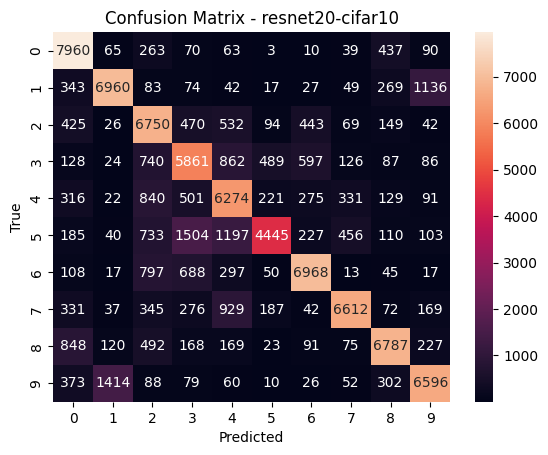

Metrics for resnet20-cifar10:
Accuracy: 0.72
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.88      0.80      9000
           1       0.80      0.77      0.79      9000
           2       0.61      0.75      0.67      9000
           3       0.60      0.65      0.63      9000
           4       0.60      0.70      0.65      9000
           5       0.80      0.49      0.61      9000
           6       0.80      0.77      0.79      9000
           7       0.85      0.73      0.79      9000
           8       0.81      0.75      0.78      9000
           9       0.77      0.73      0.75      9000

    accuracy                           0.72     90000
   macro avg       0.74      0.72      0.72     90000
weighted avg       0.74      0.72      0.72     90000



In [22]:

model_resNet.eval()
# Predykcja na zbiorze testowym
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in get_data_loader_for_memory(test_data, 256):  # lub batch_size z konfiguracji
        inputs = inputs.to(device)
        outputs = model_resNet(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # # Wyświetl metryki
    score_model(all_labels, all_preds, model_name = "resnet20-cifar10")

Fine-Tune

In [23]:
learning_rate = 0.0005
batch_size = 64
epochs = 1

for name, param in model_resNet.named_parameters():
    if 'fc' not in name:
        param.requires_grad = False

optimizer_adam_1 = torch.optim.Adam(model_resNet.parameters(), lr = learning_rate)
loss_fun_1 = nn.CrossEntropyLoss()

for epoch in range(1, epochs + 1):
    train_loss, batch_losses_train = train_one_epoch(model_resNet, get_data_loader_for_memory(fewshot_dataset, batch_size), optimizer_adam_1, loss_fun_1, device)
    val_loss, val_acc, batch_losses_valid = evaluate(model_resNet, get_data_loader_for_memory(valid_data, 256), loss_fun_1, device)
    print(f"[Epoch {epoch}/{epochs}] Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, Val acc: {val_acc:.2f}% || lr = {lr}, batch_size = {batch_size}")

[Epoch 1/1] Train loss: 1.4090, Val loss: 1.2877, Val acc: 74.61% || lr = 0.001, batch_size = 64


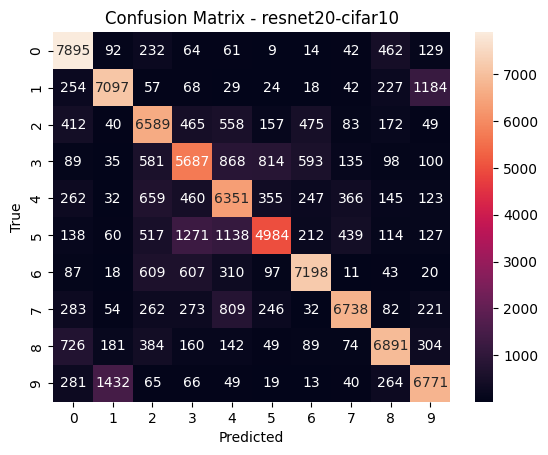

Metrics for resnet20-cifar10:
Accuracy: 0.74
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.88      0.81      9000
           1       0.78      0.79      0.79      9000
           2       0.66      0.73      0.70      9000
           3       0.62      0.63      0.63      9000
           4       0.62      0.71      0.66      9000
           5       0.74      0.55      0.63      9000
           6       0.81      0.80      0.80      9000
           7       0.85      0.75      0.79      9000
           8       0.81      0.77      0.79      9000
           9       0.75      0.75      0.75      9000

    accuracy                           0.74     90000
   macro avg       0.74      0.74      0.74     90000
weighted avg       0.74      0.74      0.74     90000



In [24]:
model_resNet.eval()
# Predykcja na zbiorze testowym
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in get_data_loader_for_memory(test_data, 256):  # lub batch_size z konfiguracji
        inputs = inputs.to(device)
        outputs = model_resNet(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # # Wyświetl metryki
    score_model(all_labels, all_preds, model_name = "resnet20-cifar10")

Ensambling

In [25]:
model_CnnComplex = ComplexCNN(dropout_rate = 0.5).to(device)
model_CnnComplex.load_state_dict(torch.load("saved_models_test_augmented_standard/model_lr0.001_bs256_ep15.pt"))

model_ResNet20 = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
model_ResNet20 = model_ResNet20.to(device)

model_mobile = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_mobilenetv2_x1_4", pretrained=True)
model_mobile = model_mobile.to(device)


/tmp/ipykernel_2556/3880472520.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_CnnComplex.load_state_dict(torch.load("saved_models_test_augmented_standard/model_lr

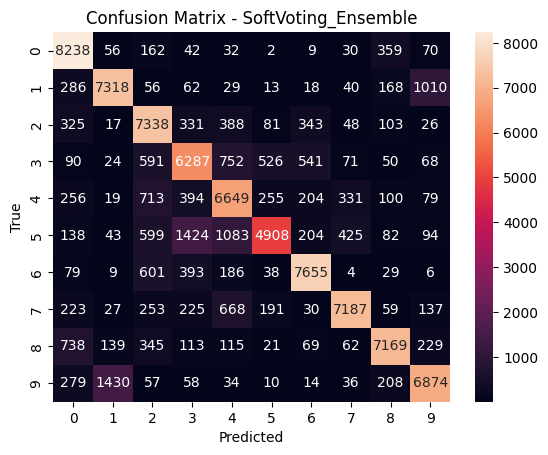

Metrics for SoftVoting_Ensemble:
Accuracy: 0.77
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.92      0.84      9000
           1       0.81      0.81      0.81      9000
           2       0.68      0.82      0.74      9000
           3       0.67      0.70      0.69      9000
           4       0.67      0.74      0.70      9000
           5       0.81      0.55      0.65      9000
           6       0.84      0.85      0.85      9000
           7       0.87      0.80      0.83      9000
           8       0.86      0.80      0.83      9000
           9       0.80      0.76      0.78      9000

    accuracy                           0.77     90000
   macro avg       0.78      0.77      0.77     90000
weighted avg       0.78      0.77      0.77     90000



In [26]:
import torch.nn.functional as F
import numpy as np

all_preds_soft = []
all_labels = []

model_CnnComplex.eval()
model_ResNet20.eval()
model_mobile.eval()

with torch.no_grad():
    for inputs, labels in get_data_loader_for_memory(test_data, 256):
        inputs = inputs.to(device)

        probs1 = F.softmax(model_CnnComplex(inputs), dim=1)
        probs2 = F.softmax(model_ResNet20(inputs), dim=1)
        probs3 = F.softmax(model_mobile(inputs), dim=1)

        avg_probs = (probs1 + probs2 + probs3) / 3
        final_preds = torch.argmax(avg_probs, dim=1)

        all_preds_soft.extend(final_preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

score_model(all_labels, all_preds_soft, model_name="SoftVoting_Ensemble")


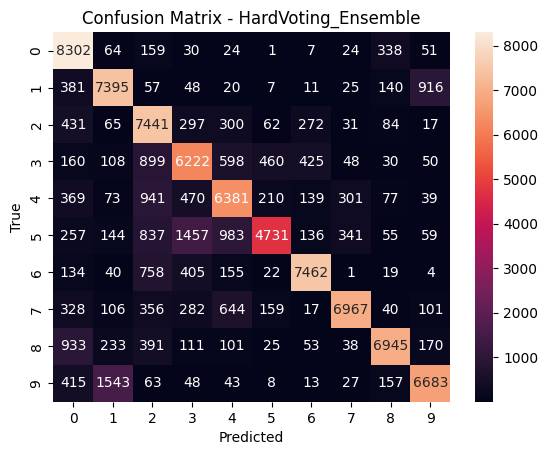

Metrics for HardVoting_Ensemble:
Accuracy: 0.76
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.92      0.80      9000
           1       0.76      0.82      0.79      9000
           2       0.63      0.83      0.71      9000
           3       0.66      0.69      0.68      9000
           4       0.69      0.71      0.70      9000
           5       0.83      0.53      0.64      9000
           6       0.87      0.83      0.85      9000
           7       0.89      0.77      0.83      9000
           8       0.88      0.77      0.82      9000
           9       0.83      0.74      0.78      9000

    accuracy                           0.76     90000
   macro avg       0.78      0.76      0.76     90000
weighted avg       0.78      0.76      0.76     90000



In [27]:
from scipy.stats import mode

all_preds_hard = []
all_labels = []

model_CnnComplex.eval()
model_ResNet20.eval()
model_mobile.eval()

with torch.no_grad():
    for inputs, labels in get_data_loader_for_memory(test_data, 256):
        inputs = inputs.to(device)

        pred1 = torch.argmax(model_CnnComplex(inputs), dim=1)
        pred2 = torch.argmax(model_ResNet20(inputs), dim=1)
        pred3 = torch.argmax(model_mobile(inputs), dim=1)

        stacked_preds = torch.stack([pred1, pred2, pred3])
        majority_preds, _ = mode(stacked_preds.cpu().numpy(), axis=0)

        all_preds_hard.extend(majority_preds.flatten())
        all_labels.extend(labels.cpu().numpy())

score_model(all_labels, all_preds_hard, model_name="HardVoting_Ensemble")


In [62]:
class EnsambleMLP(nn.Module):
    def __init__(self, input_size=30, hidden_size=64, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        return self.fc2(x)

def get_model_logits(model, dataloader):
    model.eval()
    logits = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            logits.append(probs.cpu())
    return torch.cat(logits, dim=0)


In [58]:
from torch.utils.data import TensorDataset, DataLoader

train_loader = get_data_loader_for_memory(train_data, batch_size=256, shuffle=False)
valid_loader = get_data_loader_for_memory(valid_data, batch_size=256, shuffle=False)
test_loader = get_data_loader_for_memory(test_data, batch_size=256, shuffle=False)

# Predictions from 3 models:
logits_cnn_train = get_model_logits(model_CnnComplex, train_loader)
print("[LOG] get train data from CNNComplex")
logits_resnet_train = get_model_logits(model_ResNet20, train_loader)
print("[LOG] get train data from ResNet")
logits_mobile_train = get_model_logits(model_mobile, train_loader)
print("[LOG] get train data from MobileModel")

logits_cnn_valid = get_model_logits(model_CnnComplex, valid_loader)
print("[LOG] get valid data from CNNComplex")
logits_resnet_valid = get_model_logits(model_ResNet20, valid_loader)
print("[LOG] get valid data from ResNet")
logits_mobile_valid = get_model_logits(model_mobile, valid_loader)
print("[LOG] get valid data from MobileModel")

logits_cnn_test = get_model_logits(model_CnnComplex, test_loader)
print("[LOG] get test data from CNNComplex")
logits_resnet_test = get_model_logits(model_ResNet20, test_loader)
print("[LOG] get test data from ResNet")
logits_mobile_test = get_model_logits(model_mobile, test_loader)
print("[LOG] get test data from MobileModel")

stacked_inputs_train = torch.cat([logits_cnn_train, logits_resnet_train, logits_mobile_train], dim=1)
true_labels_train = torch.tensor([label for _, label in train_data])

stacked_inputs_valid = torch.cat([logits_cnn_valid, logits_resnet_valid, logits_mobile_valid], dim=1)
true_labels_valid = torch.tensor([label for _, label in valid_data])

stacked_inputs_test = torch.cat([logits_cnn_test, logits_resnet_test, logits_mobile_test], dim=1)
true_labels_test = torch.tensor([label for _, label in test_data])


[LOG] get train data from CNNComplex
[LOG] get train data from ResNet
[LOG] get train data from MobileModel
[LOG] get valid data from CNNComplex
[LOG] get valid data from ResNet
[LOG] get valid data from MobileModel
[LOG] get test data from CNNComplex
[LOG] get test data from ResNet
[LOG] get test data from MobileModel


In [59]:
stacked_dataset_train = TensorDataset(stacked_inputs_train, true_labels_train)
stacked_loader_train = DataLoader(stacked_dataset_train, batch_size=256, shuffle=True)

stacked_dataset_valid = TensorDataset(stacked_inputs_valid, true_labels_valid)
stacked_loader_valid = DataLoader(stacked_dataset_valid, batch_size=256, shuffle=True)

stacked_dataset_test = TensorDataset(stacked_inputs_test, true_labels_test)
stacked_loader_test = DataLoader(stacked_dataset_test, batch_size=256, shuffle=True)

In [ ]:
model_ensemble = EnsambleMLP(input_size=30).to(device)
optimizer_ens  = torch.optim.Adam(model_ensemble.parameters(), lr=0.001)
loss_fun = nn.CrossEntropyLoss()

for epoch in range(1, 12):
    train_loss, _ = train_one_epoch(model_ensemble, stacked_loader_train, optimizer_ens, loss_fun, device)
    val_loss, val_acc, _ = evaluate(model_ensemble, stacked_loader_valid, loss_fun, device)
    print(f"[Epoch {epoch}/11] Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, Val acc: {val_acc:.2f}%")



[Epoch 1/10] Train loss: 0.7481, Val loss: 0.6543, Val acc: 79.08%
[Epoch 2/10] Train loss: 0.5731, Val loss: 0.6476, Val acc: 79.16%
[Epoch 3/10] Train loss: 0.5670, Val loss: 0.6454, Val acc: 79.24%
[Epoch 4/10] Train loss: 0.5630, Val loss: 0.6440, Val acc: 79.20%
[Epoch 5/10] Train loss: 0.5613, Val loss: 0.6422, Val acc: 79.26%
[Epoch 6/10] Train loss: 0.5579, Val loss: 0.6390, Val acc: 79.42%
[Epoch 7/10] Train loss: 0.5550, Val loss: 0.6387, Val acc: 79.35%
[Epoch 8/10] Train loss: 0.5528, Val loss: 0.6393, Val acc: 79.26%
[Epoch 9/10] Train loss: 0.5515, Val loss: 0.6367, Val acc: 79.30%
[Epoch 10/10] Train loss: 0.5485, Val loss: 0.6342, Val acc: 79.54%
[Epoch 11/10] Train loss: 0.5463, Val loss: 0.6339, Val acc: 79.46%


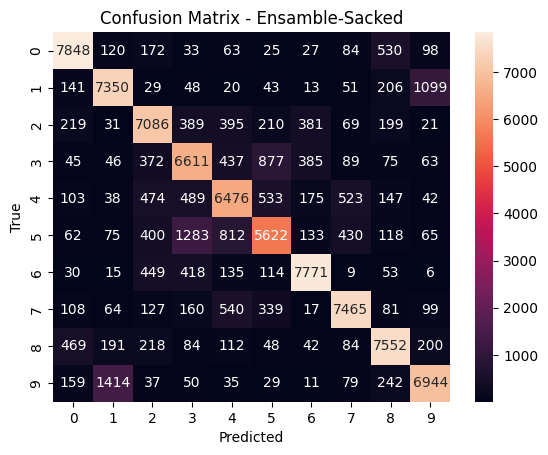

Metrics for Ensamble-Sacked:
Accuracy: 0.79
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      9000
           1       0.79      0.82      0.80      9000
           2       0.76      0.79      0.77      9000
           3       0.69      0.73      0.71      9000
           4       0.72      0.72      0.72      9000
           5       0.72      0.62      0.67      9000
           6       0.87      0.86      0.87      9000
           7       0.84      0.83      0.83      9000
           8       0.82      0.84      0.83      9000
           9       0.80      0.77      0.79      9000

    accuracy                           0.79     90000
   macro avg       0.79      0.79      0.79     90000
weighted avg       0.79      0.79      0.79     90000



In [64]:
model_ensemble.eval()
# Predykcja na zbiorze testowym
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in stacked_loader_test:  # lub batch_size z konfiguracji
        inputs = inputs.to(device)
        outputs = model_ensemble(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # # Wyświetl metryki
    score_model(all_labels, all_preds, model_name = "Ensamble-Sacked")